# Content

In this notebook we generate some random graphs from $4$ different families (Erdos-Renyi, stochastic block model, configuration model and geometric model) and make them temporal associating to each edge a temporal series of an edge of the *SP* called `high_2013`. Each graph has a varying number of nodes. We then use our distance definition to cluster the graphs according to their generative model.

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path += ['package']

from MatrixDistance import *
from GraphCreation import *
from Utilities import *

import warnings
warnings.filterwarnings("ignore")

### Get the daily activity patterns for each edge in `high_2013`

In [10]:
# we build df_SP so that it contains (i,j,t, day)
df_SP = pd.read_csv('school_data/data/High-School_data_2013.csv', header = None, sep = ' ', names = ['t', 'i', 'j','c_i','c_j'])
df_SP = df_SP[['t','i','j']]
df_SP['day'] = pd.to_datetime(df_SP.t, unit = 's')
df_SP['day'] = df_SP.day.dt.day
all_pairs = df_SP.groupby(['i', 'j', 'day']).size().reset_index()[['i', 'j', 'day']].values
df_SP.set_index(['i', 'j', 'day'], inplace = True) # <-- so this is a time series of t, where i, j and day are the indeces

timeF = []

# a pair is in the form (i, j, day) and timeF stores all the interactions between i and j on day t
for x, pair in enumerate(all_pairs):
    print(str(np.round((x+1)/len(all_pairs)*100,2)) + ' %', end = '\r')
    i, j, day = pair
    timeF.append(df_SP.loc[i, j, day].t.values) 
    
# we then construct time FR that for each (i,j,t) stores the edge time-line, centered to 00:00 of the corresponding day 
timeFR = [[] for x in range(len(timeF))]

for a, T in enumerate(timeF):
    print(str(np.round((a+1)/len(all_pairs)*100,2)) + ' %', end = '\r')
    for t in T:
        if (pd.to_datetime(t, unit = 's') - pd.to_datetime('1970-01-01 08:00:00')).days == 1:
            tt = (pd.to_datetime(t, unit = 's') - pd.to_datetime('1970-01-02 08:00:00')).total_seconds()
            
        else:
            tt = (pd.to_datetime(t, unit = 's') - pd.to_datetime('1970-01-01 08:00:00')).total_seconds()
            
        timeFR[a].append(tt)

In [15]:
# We generate a sequence of temporal graphs with n0 = 1000 as the average number of nodes and store them in the 
# list DFT. For each type we generate 250 graphs

n0 = 1000
n_graphs = 250

# variance of the graph size
γ = 0.8

DFT = []
size = []

### DCSBM
k = 5
c_in = 25
c_out = 1
C = np.ones((k,k))*c_out
C += np.diag(np.ones(k))*(c_in - c_out)
c = (c_in + (k-1)*c_out)/k
symmetric = True
make_connected = True



for i in range(n_graphs):
    print(str(100*(i+1)/n_graphs) + ' %' , end = '\r')
    
    n = np.random.randint(int(n0*(1-γ)), int(n0*(1+γ)))
    θ = np.ones(n)
    ℓ = np.zeros(n)
    for i in range(k):
        ℓ[i*int(n/k): (i+1)*int(n/k)] = i
    ℓ = ℓ.astype(int)

    args = (C, c, ℓ, θ, symmetric, make_connected)
    dft = DCSBM(args)
    DFT.append(MakeTemporal(dft, timeFR))
    size.append(n)
print('\n')
    
### ER
k = 1
C = np.ones((k,k))*c

for i in range(n_graphs):
    print(str(100*(i+1)/n_graphs) + ' %' , end = '\r')
    
    n = np.random.randint(int(n0*(1-γ)), int(n0*(1+γ)))
    ℓ = np.zeros(n).astype(int)
    θ = np.ones(n)
    args = (C, c, ℓ, θ, symmetric, make_connected)

    dft = DCSBM(args)
    DFT.append(MakeTemporal(dft, timeFR))
    size.append(n)
print('\n')

    
### Configuration model
for i in range(n_graphs):
    print(str(100*(i+1)/n_graphs) + ' %' , end = '\r')
    
    n = np.random.randint(int(n0*(1-γ)), int(n0*(1+γ)))
    θ = np.random.uniform(3,10, n)**4
    θ = θ/np.mean(θ)
    ℓ = np.zeros(n).astype(int)
    args = (C, c, ℓ, θ, symmetric, make_connected)

    
    dft = DCSBM(args)
    DFT.append(MakeTemporal(dft, timeFR))
    size.append(n)
print('\n')

### Geometric model
β = 20

for i in range(n_graphs):
    print(str(100*(i+1)/n_graphs) + ' %' , end = '\r')
    
    n = np.random.randint(int(n0*(1-γ)), int(n0*(1+γ)))
    
    r = np.random.uniform(0, 1, n)
    θ = np.random.uniform(0, 2*np.pi, n)
    X = np.zeros((n, 2))
    X[:,0] = r*np.cos(θ)
    X[:,1] = r*np.sin(θ)
    args = (X, c, β)

    
    dft = GeometricModel(args)
    DFT.append(MakeTemporal(dft, timeFR))
    
    size.append(n)

100.0 %

100.0 %

100.0 %



In [71]:
n = np.random.randint(int(n0*(1-γ)), int(n0*(1+γ)))
θ = np.random.uniform(3,10, n)**4
θ = θ/np.mean(θ)
ℓ = np.zeros(n).astype(int)
args = (C, c, ℓ, θ, symmetric, make_connected)


dft = DCSBM(args)
np.mean(dft.i > dft.j)

0.5

In [1]:
m = 5
A = nx.adjacency_matrix(nx.barabasi_albert_graph(n,m))
dft = pd.DataFrame(np.array(A.nonzero()).T, columns = ['i', 'j'])

dft

NameError: name 'nx' is not defined

In [ ]:
#import pickle

#with open('outputs/DFT.pkl', 'wb') as f:
#    pickle.dump(DFT, f)

In [ ]:
## generate the embedding of the temporal graphs

#dv = [2**(i+1) for i in range(7)]

#n = len(DFT)

#for d in dv[::-1]:
#    print(d, end = '\r')
#    print('\n')

#    λlist = []

#    for i in range(n):
#        print(str(i+1) + '/' + str(n), end = '\r')
#        N = len(np.unique(DFT[i][['i', 'j']]))
#        X = GraphDynamicEmbedding(DFT[i], dim = d, n = N, n_epochs = 20, η = 1, verbose = False)
#        s, _ = np.shape(X)
#        λlist.append(np.linalg.eigvalsh(X.T@X)/s)

#    np.savetxt('Data/Embeddings/Synthetic/embs_' + str(d) + '.txt', λlist)
#    np.savetxt('Data/Embeddings/Synthetic/size_' + str(d) + '.txt', size)

In [ ]:
## perform clustering

#dv = [2**(i+1) for i in range(7)]
#n_graphs = 250
#ℓ = np.concatenate([[i for x in range(n_graphs)] for i in range(4)])
#nmi_v = []

#for d in dv:
#    print(d, end = '\r')
    
#    # load the embedding
#    λlist = np.loadtxt('Data/Embeddings/Synthetic/embs_' + str(d) + '.txt')
#    size = np.loadtxt('Data/Embeddings/Synthetic/size_' + str(d) + '.txt')

#    # ground truth
#    gt = np.concatenate([[i for x in range(n_graphs)] for i in range(4)])

#    k = len(np.unique(gt))

#    # matrix distance
#    n, d = λlist.shape
#    D = np.zeros((n,n))

#    for i in range(n):
#        print(i, end = '\r')
#        for j in range(i+1,n):
#            D[i,j] = np.linalg.norm(λlist[i] - λlist[j])

#    D = D + D.T
#    s = NMI(ClusterNMF(D, k), ℓ)
    
#    print(f'd: {d}; nmi: {s}')
#    nmi_v.append(s)

In [ ]:
# np.savetxt('Data/Embeddings/Synthetic/vary_d.dat', np.array([dv, nmi_v]))

In [57]:
n0 = 100

# variance of the graph size
γ = 0.8



### DCSBM
k = 5
c_in = 25
c_out = 1
C = np.ones((k,k))*c_out
C += np.diag(np.ones(k))*(c_in - c_out)
c = (c_in + (k-1)*c_out)/k
symmetric = True
make_connected = True



    
n = np.random.randint(int(n0*(1-γ)), int(n0*(1+γ)))
θ = np.ones(n)
ℓ = np.zeros(n)
for i in range(k):
    ℓ[i*int(n/k): (i+1)*int(n/k)] = i
ℓ = ℓ.astype(int)

args = (C, c, ℓ, θ, symmetric, make_connected)
dft = DCSBM(args)



In [49]:
### ER
k = 1
C = np.ones((k,k))*c

    
n = np.random.randint(int(n0*(1-γ)), int(n0*(1+γ)))
ℓ = np.zeros(n).astype(int)
θ = np.ones(n)
args = (C, c, ℓ, θ, symmetric, make_connected)

dft = DCSBM(args)
    

In [55]:
### Configuration model
    
n = np.random.randint(int(n0*(1-γ)), int(n0*(1+γ)))
θ = np.random.uniform(3,10, n)**4
θ = θ/np.mean(θ)
ℓ = np.zeros(n).astype(int)
args = (C, c, ℓ, θ, symmetric, make_connected)


dft = DCSBM(args)
    

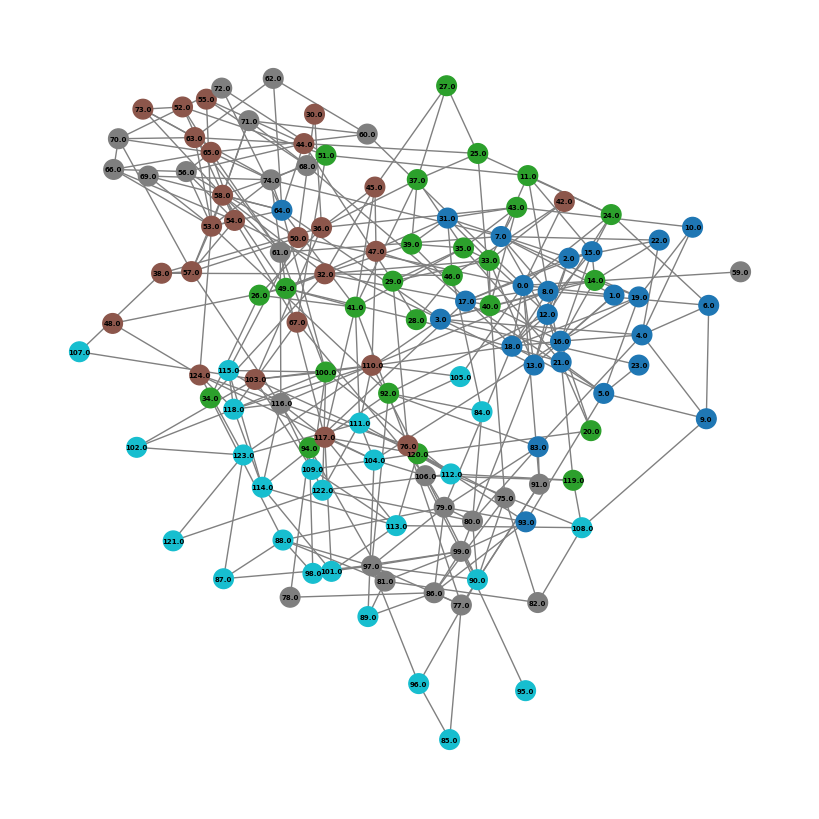

In [62]:
import networkx as nx
colors = plt.cm.get_cmap('tab10', k)
k_to_color = {com:colors(com)  for com in range(k)}

G = nx.from_pandas_edgelist(dft, 'i', 'j')

# Disegna il grafo
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_size=200, node_color=[k_to_color[i] for i in ℓ], font_size=5, font_weight='bold', edge_color='gray')
plt.show()